In [1]:
!pip install torch torchvision numpy matplotlib


Running on: cuda


100%|██████████████████████████████████████████████████████████████████████| 170M/170M [00:37<00:00, 4.54MB/s]


Data Loaded. Injected 20.0% random label noise.
Starting Training... (This may take time, grab a coffee)
Epoch 0: Train Err=74.57%, Test Err=58.03%
Epoch 5: Train Err=35.21%, Test Err=28.09%
Epoch 10: Train Err=27.88%, Test Err=29.73%
Epoch 15: Train Err=22.99%, Test Err=33.70%
Epoch 20: Train Err=18.77%, Test Err=33.36%
Epoch 25: Train Err=16.58%, Test Err=41.82%
Epoch 30: Train Err=15.05%, Test Err=38.49%
Epoch 35: Train Err=14.29%, Test Err=37.18%
Epoch 40: Train Err=14.10%, Test Err=41.63%
Epoch 45: Train Err=13.92%, Test Err=37.02%
Epoch 50: Train Err=13.52%, Test Err=39.77%
Epoch 55: Train Err=13.37%, Test Err=36.65%
Epoch 60: Train Err=3.49%, Test Err=28.25%
Epoch 65: Train Err=0.00%, Test Err=26.97%
Epoch 70: Train Err=0.00%, Test Err=26.80%
Epoch 75: Train Err=0.00%, Test Err=26.78%
Epoch 80: Train Err=0.00%, Test Err=26.59%
Epoch 85: Train Err=0.00%, Test Err=26.37%
Epoch 90: Train Err=0.00%, Test Err=26.44%
Epoch 95: Train Err=0.00%, Test Err=26.08%
Epoch 100: Train Err=0.00

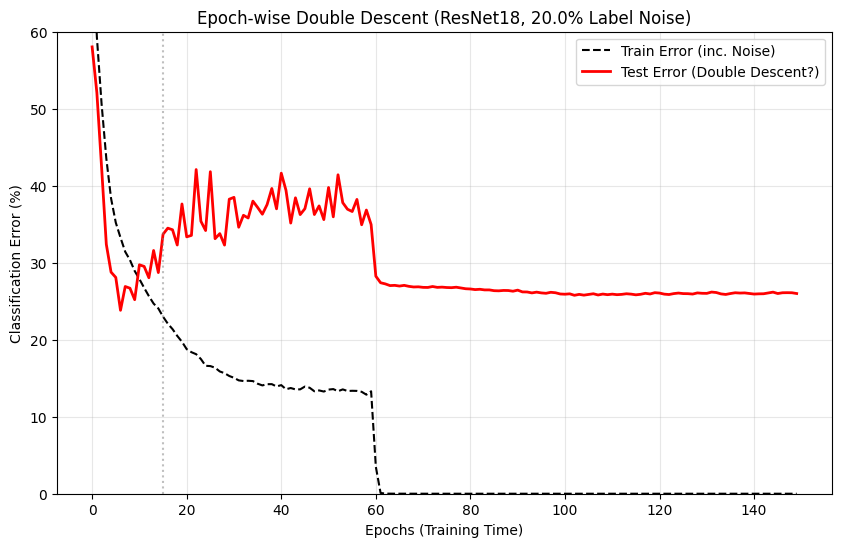

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# Part 6: Deep Double Descent & Label Noise
# ==========================================

# Configuration
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 150  # Needed to see the "second descent"
LABEL_NOISE_RATIO = 0.20  # 20% of labels will be random
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running on: {DEVICE}")

# 1. Prepare Data (with Label Noise Injection)
# We deliberately remove Data Augmentation to isolate the Double Descent phenomenon
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Inject Label Noise
# We manually corrupt the targets to force the model to memorize "bad" data
targets = np.array(train_set.targets)
n_noisy = int(len(targets) * LABEL_NOISE_RATIO)
noisy_indices = np.random.choice(len(targets), n_noisy, replace=False)
# Assign random labels to the chosen indices
targets[noisy_indices] = np.random.randint(0, 10, size=n_noisy)
train_set.targets = targets.tolist()

print(f"Data Loaded. Injected {LABEL_NOISE_RATIO*100}% random label noise.")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Define Model (ResNet18)
# We use a standard ResNet18. It is sufficiently "over-parameterized" for CIFAR-10.
# We modify the first layer to handle small CIFAR images (3x3 kernel instead of 7x7)
def get_cifar_resnet():
    model = torchvision.models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() # Remove maxpool to preserve spatial dim for small images
    model.fc = nn.Linear(512, 10)
    return model.to(DEVICE)

model = get_cifar_resnet()
criterion = nn.CrossEntropyLoss()
# SGD without weight decay (or very low) often makes the peak sharper
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005) 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120], gamma=0.1)

# 3. Training Loop with Tracking
train_err_history = []
test_err_history = []
epoch_history = []

print("Starting Training... (This may take time, grab a coffee)")

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_acc = 100. * correct / total
    train_err = 100.0 - train_acc
    
    # Evaluate
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
    test_acc = 100. * test_correct / test_total
    test_err = 100.0 - test_acc
    
    # Store
    train_err_history.append(train_err)
    test_err_history.append(test_err)
    epoch_history.append(epoch)
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Err={train_err:.2f}%, Test Err={test_err:.2f}%")

# 4. Visualization: The Epoch-wise Double Descent Curve
plt.figure(figsize=(10, 6))
plt.plot(epoch_history, train_err_history, 'k--', label='Train Error (inc. Noise)')
plt.plot(epoch_history, test_err_history, 'r-', linewidth=2, label='Test Error (Double Descent?)')

plt.title(f'Epoch-wise Double Descent (ResNet18, {LABEL_NOISE_RATIO*100}% Label Noise)')
plt.xlabel('Epochs (Training Time)')
plt.ylabel('Classification Error (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=15, color='gray', linestyle=':', alpha=0.5, label='Interpolation Threshold (Approx)')

# Important: Scale Y-axis to focus on the phenomenon
plt.ylim(0, 60) 

plt.show()

Running on: cuda


100%|██████████████████████████████████████████████████████████████████████| 169M/169M [00:21<00:00, 8.04MB/s]


Data Loaded. Injected 20.0% random label noise.
Starting Training... (This may take time, grab a coffee)
Epoch 0: Train Err=92.24%, Test Err=86.27%
Epoch 5: Train Err=59.38%, Test Err=59.17%
Epoch 10: Train Err=43.67%, Test Err=58.53%
Epoch 15: Train Err=32.67%, Test Err=61.17%
Epoch 20: Train Err=25.75%, Test Err=65.44%
Epoch 25: Train Err=22.71%, Test Err=67.66%
Epoch 30: Train Err=22.09%, Test Err=68.18%
Epoch 35: Train Err=20.79%, Test Err=65.25%
Epoch 40: Train Err=19.46%, Test Err=64.39%
Epoch 45: Train Err=19.49%, Test Err=69.30%
Epoch 50: Train Err=19.27%, Test Err=67.82%
Epoch 55: Train Err=20.21%, Test Err=69.13%
Epoch 60: Train Err=5.46%, Test Err=56.03%
Epoch 65: Train Err=0.05%, Test Err=54.44%
Epoch 70: Train Err=0.04%, Test Err=54.06%
Epoch 75: Train Err=0.03%, Test Err=53.59%
Epoch 80: Train Err=0.03%, Test Err=53.77%
Epoch 85: Train Err=0.03%, Test Err=53.89%
Epoch 90: Train Err=0.03%, Test Err=53.82%
Epoch 95: Train Err=0.03%, Test Err=53.86%
Epoch 100: Train Err=0.04

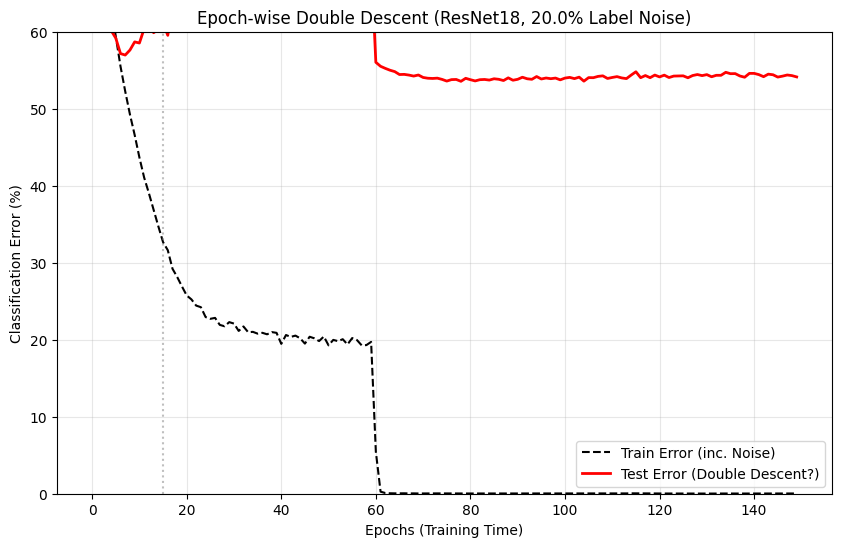

In [4]:
# Change dataset

# Configuration
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 150  # Needed to see the "second descent"
LABEL_NOISE_RATIO = 0.20  # 20% of labels will be random
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running on: {DEVICE}")

# 1. Prepare Data (with Label Noise Injection)
# We deliberately remove Data Augmentation to isolate the Double Descent phenomenon
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Inject Label Noise
# We manually corrupt the targets to force the model to memorize "bad" data
targets = np.array(train_set.targets)
n_noisy = int(len(targets) * LABEL_NOISE_RATIO)
noisy_indices = np.random.choice(len(targets), n_noisy, replace=False)
# Assign random labels to the chosen indices
targets[noisy_indices] = np.random.randint(0, 10, size=n_noisy)
train_set.targets = targets.tolist()

print(f"Data Loaded. Injected {LABEL_NOISE_RATIO*100}% random label noise.")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Define Model (ResNet18)
# We use a standard ResNet18. It is sufficiently "over-parameterized" for CIFAR-10.
# We modify the first layer to handle small CIFAR images (3x3 kernel instead of 7x7)
def get_cifar_resnet():
    model = torchvision.models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() # Remove maxpool to preserve spatial dim for small images
    model.fc = nn.Linear(512, 100)
    return model.to(DEVICE)

model = get_cifar_resnet()
criterion = nn.CrossEntropyLoss()
# SGD without weight decay (or very low) often makes the peak sharper
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005) 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120], gamma=0.1)

# 3. Training Loop with Tracking
train_err_history = []
test_err_history = []
epoch_history = []

print("Starting Training... (This may take time, grab a coffee)")

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_acc = 100. * correct / total
    train_err = 100.0 - train_acc
    
    # Evaluate
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
    test_acc = 100. * test_correct / test_total
    test_err = 100.0 - test_acc
    
    # Store
    train_err_history.append(train_err)
    test_err_history.append(test_err)
    epoch_history.append(epoch)
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Err={train_err:.2f}%, Test Err={test_err:.2f}%")

# 4. Visualization: The Epoch-wise Double Descent Curve
plt.figure(figsize=(10, 6))
plt.plot(epoch_history, train_err_history, 'k--', label='Train Error (inc. Noise)')
plt.plot(epoch_history, test_err_history, 'r-', linewidth=2, label='Test Error (Double Descent?)')

plt.title(f'Epoch-wise Double Descent (ResNet18, {LABEL_NOISE_RATIO*100}% Label Noise)')
plt.xlabel('Epochs (Training Time)')
plt.ylabel('Classification Error (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=15, color='gray', linestyle=':', alpha=0.5, label='Interpolation Threshold (Approx)')

# Important: Scale Y-axis to focus on the phenomenon
plt.ylim(0, 60) 

plt.show()

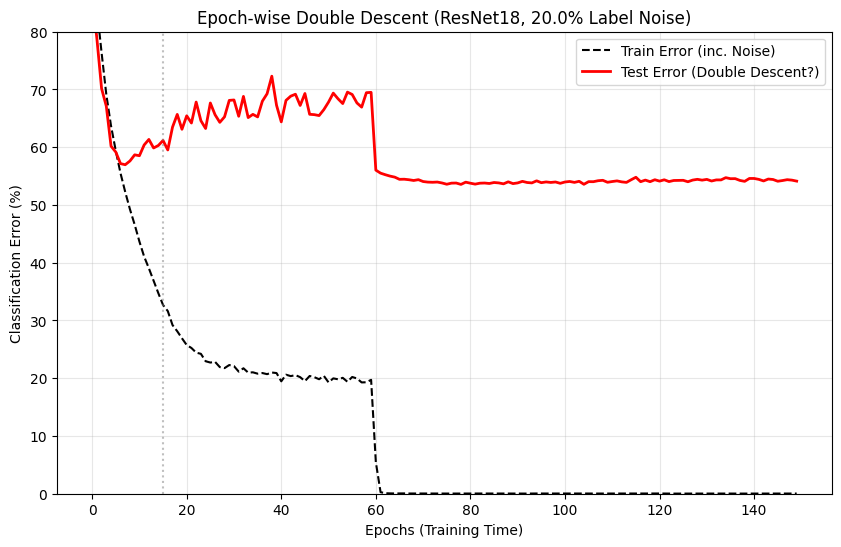

In [5]:

# 4. Visualization: The Epoch-wise Double Descent Curve
plt.figure(figsize=(10, 6))
plt.plot(epoch_history, train_err_history, 'k--', label='Train Error (inc. Noise)')
plt.plot(epoch_history, test_err_history, 'r-', linewidth=2, label='Test Error (Double Descent?)')

plt.title(f'Epoch-wise Double Descent (ResNet18, {LABEL_NOISE_RATIO*100}% Label Noise)')
plt.xlabel('Epochs (Training Time)')
plt.ylabel('Classification Error (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=15, color='gray', linestyle=':', alpha=0.5, label='Interpolation Threshold (Approx)')

# Important: Scale Y-axis to focus on the phenomenon
plt.ylim(0, 80) 

plt.show()

In [9]:
!pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 11.3 MB/s eta 0:00:000:00:01m eta 0:00:01


Running on: cuda
Downloading/Loading SVHN Data...


100%|████████████████████████████████████████████████████████████████████| 64.3M/64.3M [00:10<00:00, 5.89MB/s]


Injecting 20.0% label noise (14651 images)...
Starting Training...
Epoch 0: Train Err=83.06%, Test Err=78.00%
Epoch 5: Train Err=23.42%, Test Err=9.61%
Epoch 10: Train Err=22.39%, Test Err=9.07%
Epoch 15: Train Err=21.54%, Test Err=8.13%
Epoch 20: Train Err=21.06%, Test Err=9.27%
Epoch 25: Train Err=20.35%, Test Err=10.33%
Epoch 30: Train Err=19.78%, Test Err=13.89%
Epoch 35: Train Err=19.15%, Test Err=13.31%
Epoch 40: Train Err=18.45%, Test Err=14.60%
Epoch 45: Train Err=17.89%, Test Err=15.06%
Epoch 50: Train Err=17.60%, Test Err=18.27%
Epoch 55: Train Err=16.94%, Test Err=16.73%
Epoch 60: Train Err=4.89%, Test Err=14.48%
Epoch 65: Train Err=0.03%, Test Err=12.83%
Epoch 70: Train Err=0.03%, Test Err=12.46%
Epoch 75: Train Err=0.02%, Test Err=12.07%
Epoch 80: Train Err=0.02%, Test Err=11.73%
Epoch 85: Train Err=0.03%, Test Err=11.53%
Epoch 90: Train Err=0.03%, Test Err=11.33%
Epoch 95: Train Err=0.03%, Test Err=11.25%
Epoch 100: Train Err=0.03%, Test Err=11.04%
Epoch 105: Train Err=0.

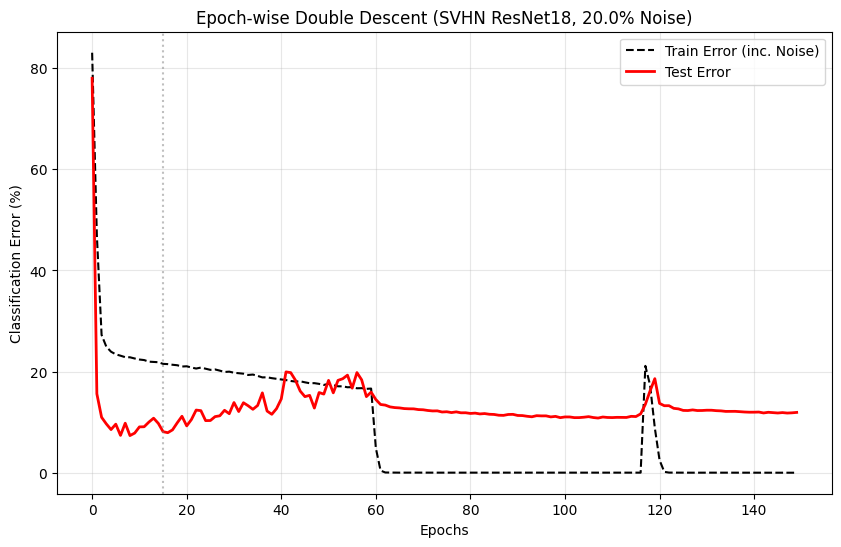

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt

# ==========================================
# Part 6: Deep Double Descent on SVHN
# ==========================================

def run_experiment():
    # --- Configuration ---
    BATCH_SIZE = 128
    LR = 0.1
    EPOCHS = 150        # High epoch count needed to see the second descent
    LABEL_NOISE_RATIO = 0.20  # 20% of labels will be corrupted
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Running on: {DEVICE}")

    # --- 1. Data Preparation (SVHN with Noise) ---
    # SVHN is 32x32. We normalize to [-1, 1] range.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    print("Downloading/Loading SVHN Data...")
    # SVHN uses 'split' instead of 'train', and stores labels in .labels (numpy array)
    train_set = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
    test_set = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

    # Inject Label Noise
    # We corrupt 'n_noisy' labels to force the model to memorize random data
    targets = np.array(train_set.labels)
    n_noisy = int(len(targets) * LABEL_NOISE_RATIO)
    noisy_indices = np.random.choice(len(targets), n_noisy, replace=False)
    
    # SVHN has classes 0-9. We assign random integers in that range.
    print(f"Injecting {LABEL_NOISE_RATIO*100}% label noise ({n_noisy} images)...")
    targets[noisy_indices] = np.random.randint(0, 10, size=n_noisy)
    train_set.labels = targets # Update the dataset with noisy labels

    # Data Loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- 2. Define Model (Modified ResNet18) ---
    # Standard ResNet18 is for 224x224 images. We must modify the start 
    # to handle 32x32 images without destroying spatial information.
    def get_svhn_resnet():
        model = torchvision.models.resnet18(weights=None)
        # Change 7x7 kernel with stride 2 -> 3x3 kernel with stride 1
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove the first MaxPool (which would reduce 32x32 -> 16x16 too early)
        model.maxpool = nn.Identity() 
        # Output layer for 10 classes
        model.fc = nn.Linear(512, 10)
        return model.to(DEVICE)

    model = get_svhn_resnet()
    criterion = nn.CrossEntropyLoss()
    # SGD without heavy weight decay allows the "interpolation" regime to form easier
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
    # Decay learning rate at epoch 60 and 120
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120], gamma=0.1)

    # --- 3. Training Loop ---
    train_err_history = []
    test_err_history = []
    epoch_history = []

    print("Starting Training...")

    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100. * correct / total
        train_err = 100.0 - train_acc
        
        # Evaluate on Test Set
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
        test_acc = 100. * test_correct / test_total
        test_err = 100.0 - test_acc
        
        # Store metrics
        train_err_history.append(train_err)
        test_err_history.append(test_err)
        epoch_history.append(epoch)
        
        scheduler.step()
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Train Err={train_err:.2f}%, Test Err={test_err:.2f}%")

    # --- 4. Visualization ---
    print("Training Complete. Plotting results...")
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_history, train_err_history, 'k--', label='Train Error (inc. Noise)')
    plt.plot(epoch_history, test_err_history, 'r-', linewidth=2, label='Test Error')

    plt.title(f'Epoch-wise Double Descent (SVHN ResNet18, {LABEL_NOISE_RATIO*100}% Noise)')
    plt.xlabel('Epochs')
    plt.ylabel('Classification Error (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Visual marker for the "interpolation threshold" area (approximate)
    plt.axvline(x=15, color='gray', linestyle=':', alpha=0.5)

    # Save to file (since you are on mobile/server)
    plt.savefig('svhn_double_descent.png')
    print("Plot saved to 'svhn_double_descent.png'")
    plt.show()

# Windows/Multiprocessing protection
if __name__ == '__main__':
    run_experiment()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import shutil
from torchvision.datasets import ImageFolder

# ==========================================
# Part 7: Deep Double Descent on Tiny ImageNet
# ==========================================

def download_and_format_tiny_imagenet(root='./data'):
    """
    Downloads Tiny ImageNet, extracts it, and reformats the validation folder
    so PyTorch's ImageFolder can read it.
    """
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    dataset_path = os.path.join(root, 'tiny-imagenet-200')
    
    if os.path.exists(dataset_path):
        print("Tiny ImageNet found. Skipping download.")
        return dataset_path

    print("Downloading Tiny ImageNet (approx 240MB)...")
    os.makedirs(root, exist_ok=True)
    zip_path = os.path.join(root, 'tiny-imagenet-200.zip')
    
    # Stream download
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(root)
    
    # --- The Cleanup Job ---
    # The 'val' folder in Tiny ImageNet is unstructured. We must organize it.
    print("Reformatting Validation Set structure...")
    val_dir = os.path.join(dataset_path, 'val')
    img_dir = os.path.join(val_dir, 'images')
    annot_file = os.path.join(val_dir, 'val_annotations.txt')
    
    # 1. Read annotations: "val_0.JPEG   n01443537 ..."
    with open(annot_file, 'r') as f:
        lines = f.readlines()
        
    val_img_to_class = {}
    for line in lines:
        parts = line.strip().split('\t')
        val_img_to_class[parts[0]] = parts[1]
        
    # 2. Create subfolders for each class
    for img_file, class_id in val_img_to_class.items():
        class_dir = os.path.join(val_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)
        
        # Move image: val/images/X.jpg -> val/class_id/X.jpg
        src = os.path.join(img_dir, img_file)
        dst = os.path.join(class_dir, img_file)
        if os.path.exists(src):
            shutil.move(src, dst)
            
    # 3. Cleanup empty 'images' folder
    if os.path.exists(img_dir) and not os.listdir(img_dir):
        os.rmdir(img_dir)
        
    print("Tiny ImageNet is ready.")
    return dataset_path

def run_experiment():
    # --- Configuration ---
    # Reduced batch size to 64 to be safe with 8GB VRAM on 64x64 images
    BATCH_SIZE = 64 
    LR = 0.1
    EPOCHS = 250        # Increased epochs for the harder dataset
    LABEL_NOISE_RATIO = 0.20
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Running on: {DEVICE}")

    # --- 1. Data Preparation ---
    data_root = download_and_format_tiny_imagenet()
    
    # Tiny ImageNet is 64x64.
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(), # Minimal augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ])

    train_dir = os.path.join(data_root, 'train')
    val_dir = os.path.join(data_root, 'val')

    train_set = ImageFolder(train_dir, transform=transform_train)
    test_set = ImageFolder(val_dir, transform=transform_test)

    # --- Inject Label Noise (The Tricky Part for ImageFolder) ---
    # ImageFolder uses .samples which is a list of (path, class_idx)
    # We must modify this list directly.
    print(f"Injecting {LABEL_NOISE_RATIO*100}% label noise...")
    
    n_samples = len(train_set.samples)
    n_noisy = int(n_samples * LABEL_NOISE_RATIO)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    noisy_indices_set = set(noisy_indices) # for O(1) lookup
    
    new_samples = []
    # Tiny ImageNet has 200 classes
    for i, (path, target) in enumerate(train_set.samples):
        if i in noisy_indices_set:
            # Assign random label (0 to 199)
            new_target = np.random.randint(0, 200)
            new_samples.append((path, new_target))
        else:
            new_samples.append((path, target))
            
    train_set.samples = new_samples
    # ImageFolder caches targets in .targets too, update that just in case
    train_set.targets = [s[1] for s in new_samples]

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    print(f"Data Loaded. {len(train_set)} training images, {len(test_set)} test images.")

    # --- 2. Define Model (ResNet18 adapted for 64x64) ---
    def get_tiny_resnet():
        model = torchvision.models.resnet18(weights=None)
        
        # Conv1: 7x7 stride 2 -> 3x3 stride 1
        # This keeps the 64x64 spatial dim longer
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Remove MaxPool. 
        # If we kept MaxPool, 64x64 -> 32x32 immediately. 
        # Removing it gives us more 'depth' of resolution.
        model.maxpool = nn.Identity()
        
        # Tiny ImageNet has 200 classes
        model.fc = nn.Linear(512, 200)
        return model.to(DEVICE)

    model = get_tiny_resnet()
    criterion = nn.CrossEntropyLoss()
    # SGD with standard momentum
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
    
    # Schedule: Decay LR significantly to help the "Descent"
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 180], gamma=0.1)

    # --- 3. Training Loop ---
    train_err_history = []
    test_err_history = []
    epoch_history = []

    print("Starting Training (250 Epochs)...")

    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100. * correct / total
        train_err = 100.0 - train_acc
        
        # Evaluate
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
        test_acc = 100. * test_correct / test_total
        test_err = 100.0 - test_acc
        
        train_err_history.append(train_err)
        test_err_history.append(test_err)
        epoch_history.append(epoch)
        
        scheduler.step()
        
        # Print less frequently to keep terminal clean
        if epoch % 1 == 0:
            print(f"Epoch {epoch}: Train Err={train_err:.2f}%, Test Err={test_err:.2f}%")

    # --- 4. Visualization ---
    plt.figure(figsize=(12, 7))
    plt.plot(epoch_history, train_err_history, 'k--', label='Train Error (inc. Noise)')
    plt.plot(epoch_history, test_err_history, 'r-', linewidth=2, label='Test Error')

    plt.title(f'Tiny ImageNet Double Descent (ResNet18, {LABEL_NOISE_RATIO*100}% Noise)')
    plt.xlabel('Epochs')
    plt.ylabel('Classification Error (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 90) # Tiny ImageNet is hard, errors will be high
    
    plt.savefig('tiny_imagenet_dd.png')
    print("Plot saved to 'tiny_imagenet_dd.png'")
    plt.show()

if __name__ == '__main__':
    run_experiment()

Running on: cuda
Extracting...
Reformatting Validation Set structure...
Tiny ImageNet is ready.
Injecting 20.0% label noise...
Data Loaded. 100000 training images, 10000 test images.
Starting Training (250 Epochs)...
Epoch 0: Train Err=97.24%, Test Err=94.48%
Epoch 1: Train Err=91.48%, Test Err=86.82%
Epoch 2: Train Err=86.18%, Test Err=83.56%
Epoch 3: Train Err=82.91%, Test Err=83.64%
Epoch 4: Train Err=80.59%, Test Err=78.95%
Epoch 5: Train Err=78.41%, Test Err=72.30%
Epoch 6: Train Err=77.02%, Test Err=75.05%
Epoch 7: Train Err=75.82%, Test Err=74.92%
Epoch 8: Train Err=74.93%, Test Err=76.11%
Epoch 9: Train Err=74.17%, Test Err=74.87%
Epoch 10: Train Err=73.81%, Test Err=74.83%
Epoch 11: Train Err=73.35%, Test Err=72.40%
Epoch 12: Train Err=73.14%, Test Err=72.21%
Epoch 13: Train Err=72.78%, Test Err=71.35%
Epoch 14: Train Err=72.39%, Test Err=75.35%
Epoch 15: Train Err=72.30%, Test Err=71.82%
Epoch 16: Train Err=72.11%, Test Err=70.38%
Epoch 17: Train Err=71.94%, Test Err=72.14%
E

KeyboardInterrupt: 

Plot saved to 'tiny_imagenet_dd.png'


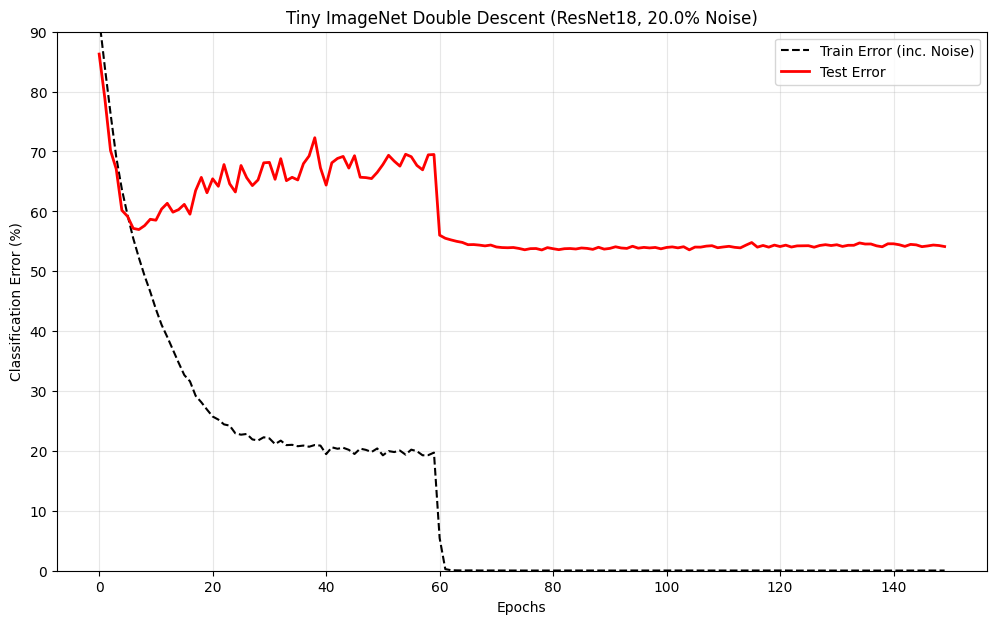

In [13]:
# --- 4. Visualization ---
plt.figure(figsize=(12, 7))
plt.plot(epoch_history, train_err_history, 'k--', label='Train Error (inc. Noise)')
plt.plot(epoch_history, test_err_history, 'r-', linewidth=2, label='Test Error')

plt.title(f'Tiny ImageNet Double Descent (ResNet18, {LABEL_NOISE_RATIO*100}% Noise)')
plt.xlabel('Epochs')
plt.ylabel('Classification Error (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 90) # Tiny ImageNet is hard, errors will be high

plt.savefig('tiny_imagenet_dd.png')
print("Plot saved to 'tiny_imagenet_dd.png'")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import shutil
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import _LRScheduler

# ==========================================
# Part 7: Tiny ImageNet Baseline (WideResNet Check)
# ==========================================

# --- CONFIGURATION ---
LABEL_NOISE_RATIO = 0.0  # Clean data
BATCH_SIZE = 48         # Optimized for 8GB VRAM (Sweet spot between 32 and 64)
LR_INIT = 0.015         # Scaled LR: 0.01 * (48/32) approx 0.015
EPOCHS = 15             # Short run
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def download_and_format_tiny_imagenet(root='./data'):
    """
    Downloads Tiny ImageNet, extracts it, and reformats the validation folder.
    """
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    dataset_path = os.path.join(root, 'tiny-imagenet-200')
    
    if os.path.exists(dataset_path):
        print("Tiny ImageNet found. Skipping download.")
        return dataset_path

    print("Downloading Tiny ImageNet (approx 240MB)...")
    os.makedirs(root, exist_ok=True)
    zip_path = os.path.join(root, 'tiny-imagenet-200.zip')
    
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(root)
    
    print("Reformatting Validation Set structure...")
    val_dir = os.path.join(dataset_path, 'val')
    img_dir = os.path.join(val_dir, 'images')
    annot_file = os.path.join(val_dir, 'val_annotations.txt')
    
    with open(annot_file, 'r') as f:
        lines = f.readlines()
        
    val_img_to_class = {}
    for line in lines:
        parts = line.strip().split('\t')
        val_img_to_class[parts[0]] = parts[1]
        
    for img_file, class_id in val_img_to_class.items():
        class_dir = os.path.join(val_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)
        src = os.path.join(img_dir, img_file)
        dst = os.path.join(class_dir, img_file)
        if os.path.exists(src):
            shutil.move(src, dst)
            
    if os.path.exists(img_dir) and not os.listdir(img_dir):
        os.rmdir(img_dir)
        
    print("Tiny ImageNet is ready.")
    return dataset_path

# --- Custom Warmup Scheduler ---
class WarmupMultiStepLR(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, milestones, gamma=0.1, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.milestones = milestones
        self.gamma = gamma
        super(WarmupMultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [base_lr * ((self.last_epoch + 1) / self.warmup_epochs) for base_lr in self.base_lrs]
        else:
            factor = 1.0
            for milestone in self.milestones:
                if self.last_epoch >= milestone:
                    factor *= self.gamma
            return [base_lr * factor for base_lr in self.base_lrs]

def run_experiment():
    print(f"Running on: {DEVICE}")
    print(f"Model: Wide ResNet-50-2 (Heavy Capacity)")
    print(f"Mode: {'CLEAN BASELINE' if LABEL_NOISE_RATIO == 0 else 'NOISY DOUBLE DESCENT'}")

    # --- 1. Data Preparation ---
    data_root = download_and_format_tiny_imagenet()
    
    norm_mean = (0.4802, 0.4481, 0.3975)
    norm_std = (0.2302, 0.2265, 0.2262)

    transform_train = transforms.Compose([
        transforms.RandomCrop(64, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

    train_dir = os.path.join(data_root, 'train')
    val_dir = os.path.join(data_root, 'val')

    train_set = ImageFolder(train_dir, transform=transform_train)
    test_set = ImageFolder(val_dir, transform=transform_test)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    # --- 2. Define Model (Wide ResNet) ---
    def get_wide_resnet():
        # Wide ResNet-50-2: Standard ResNet50 but with 2x width in bottlenecks
        model = torchvision.models.wide_resnet50_2(weights=None)
        
        # Modify Stem for 64x64 inputs
        # Original: 7x7 stride 2 -> 3x3 stride 1
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        
        # Output layer for 200 classes
        # WideResNet50's final expansion is 2048 channels
        model.fc = nn.Linear(2048, 200)
        
        return model.to(DEVICE)

    model = get_wide_resnet()
    criterion = nn.CrossEntropyLoss()
    
    # SGD (No Adam, as requested)
    optimizer = optim.SGD(model.parameters(), lr=LR_INIT, momentum=0.9, weight_decay=5e-4)
    
    # Scheduler: Warmup 3, Drop at 8 and 12 (Accelerated schedule for 15 epochs)
    scheduler = WarmupMultiStepLR(optimizer, warmup_epochs=3, milestones=[8, 12], gamma=0.1)

    # --- 3. Training Loop ---
    train_err_history = []
    test_err_history = []
    epoch_history = []

    print(f"Starting Training ({EPOCHS} Epochs)...")

    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100. * correct / total
        train_err = 100.0 - train_acc
        
        # Evaluate
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
        test_acc = 100. * test_correct / test_total
        test_err = 100.0 - test_acc
        
        train_err_history.append(train_err)
        test_err_history.append(test_err)
        epoch_history.append(epoch)
        
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        print(f"Epoch {epoch}: Train Acc={train_acc:.2f}% | Test Acc={test_acc:.2f}% | LR={current_lr:.4f}")

    # --- 4. Visualization ---
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_history, train_err_history, 'k--', label='Train Error')
    plt.plot(epoch_history, test_err_history, 'b-', linewidth=2, label='Test Error')

    plt.title(f'WideResNet-50-2 Baseline (15 Epochs)')
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('tiny_imagenet_wide_check.png')
    print("Plot saved to 'tiny_imagenet_wide_check.png'")
    plt.show()

if __name__ == '__main__':
    run_experiment()

Running on: cuda
Model: Wide ResNet-50-2 (Heavy Capacity)
Mode: CLEAN BASELINE
Tiny ImageNet found. Skipping download.
Starting Training (15 Epochs)...
Epoch 0: Train Acc=4.55% | Test Acc=9.99% | LR=0.0050
Epoch 1: Train Acc=12.89% | Test Acc=17.59% | LR=0.0100
Epoch 2: Train Acc=20.60% | Test Acc=24.35% | LR=0.0150
